In [ ]:
# Dependencias globales

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

In [ ]:
# Dependencias Especificas

import pmdarima as pm

In [ ]:
# Dependencias Específicas 

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from sklearn.neural_network import MLPRegressor


In [23]:
# Se define una función para evaluar las métricas

def evaluacion_metrica(y_true, y_pred):

  def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  print('Evaluation metrics results:\n')
  print(f'MAE is:{metrics.mean_absolute_error(y_true, y_pred)}')
  print(f'MSE is:{metrics.mean_squared_error(y_true, y_pred)}')
  print(f'RMSE is:{np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
  print(f'MAPE is:{mean_absolute_percentage_error(y_true, y_pred)}')
  print(f'R2 is:{metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [42]:
df_prod = pd.read_csv(r"C:\Users\guerr\VSC\10_Time_Series\data\VM_Production.csv", parse_dates=['Date'])
#df_prod.set_index('Date', inplace=True)
df_prod.head()


,Date,online_wells,oil_m3,gas_miles_m3,water_m3,inj_water_m3,inj_gas_m3
0,2006-01-01,195.0,1070.010500,32508.01064,993.13246,0.0,0.0
1,2006-02-01,196.0,994.508520,30792.90172,795.49068,0.0,0.0
2,2006-03-01,197.0,1136.835127,33042.57282,923.24665,0.0,0.0
3,2006-04-01,197.0,1113.681116,31362.11719,827.89328,0.0,0.0
4,2006-05-01,197.0,1505.214992,39218.73137,1358.45458,0.0,0.0


In [43]:
# Reemplazar valores no válidos en la columna 'Date'
df_prod['Date'] = df_prod['Date'].replace("(blank)", pd.NA)

# Convertir a datetime, forzando errores a NaT
df_prod['Date'] = pd.to_datetime(df_prod['Date'], errors='coerce')

# Eliminar filas con fechas inválidas
df_prod = df_prod.dropna(subset=['Date'])

# Verificá el resultado
df_prod.info()


<class 'pandas.core.frame.DataFrame'>
Index: 230 entries, 0 to 229
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          230 non-null    datetime64[ns]
 1   online_wells  230 non-null    float64       
 2   oil_m3        230 non-null    float64       
 3   gas_miles_m3  230 non-null    float64       
 4   water_m3      230 non-null    float64       
 5   inj_water_m3  230 non-null    float64       
 6   inj_gas_m3    230 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 14.4 KB


In [44]:
# Ahora necesito que la columna de DATE sea mi index, y tiene que ser regular

# Establecer la columna 'Date' como índice
df_prod = df_prod.set_index('Date')

# Asegurar intervalos mensuales con inicio de mes
df_prod = df_prod.asfreq('MS')  # 'MS' = Month Start

df_prod = df_prod.fillna(method='ffill')  # Rellenar hacia adelante

# Visualizar
df_prod.head()


C:\Users\guerr\AppData\Local\Temp\ipykernel_31972\1832298836.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prod = df_prod.fillna(method='ffill')  # Rellenar hacia adelante


,online_wells,oil_m3,gas_miles_m3,water_m3,inj_water_m3,inj_gas_m3
Date,,,,,,
2006-01-01,195.0,1070.010500,32508.01064,993.13246,0.0,0.0
2006-02-01,196.0,994.508520,30792.90172,795.49068,0.0,0.0
2006-03-01,197.0,1136.835127,33042.57282,923.24665,0.0,0.0
2006-04-01,197.0,1113.681116,31362.11719,827.89328,0.0,0.0
2006-05-01,197.0,1505.214992,39218.73137,1358.45458,0.0,0.0


In [45]:
df_frac = pd.read_csv(r"C:\Users\guerr\VSC\10_Time_Series\data\VM_Fractures.csv", parse_dates=['Date'])
#df_frac.set_index('Date', inplace=True)
df_frac.head()

,Date,Cantidad_Fracturas
0,2010-01-01,2
1,2010-02-01,1
2,2010-04-01,4
3,2010-05-01,1
4,2010-07-01,1


In [46]:
# Reemplazar valores no válidos en la columna 'Date'
df_frac['Date'] = df_frac['Date'].replace("(blank)", pd.NA)

# Convertir a datetime, forzando errores a NaT
df_frac['Date'] = pd.to_datetime(df_frac['Date'], errors='coerce')

# Eliminar filas con fechas inválidas
df_frac = df_frac.dropna(subset=['Date'])

# Verificá el resultado
df_frac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                174 non-null    datetime64[ns]
 1   Cantidad_Fracturas  174 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


In [47]:
# Establecer la columna 'Date' como índice
df_frac = df_frac.set_index('Date')

# Asegurar intervalos mensuales con inicio de mes
df_frac = df_frac.asfreq('MS')  # 'MS' = Month Start

df_frac = df_frac.fillna(method='ffill')  # Rellenar hacia adelante

# Visualizar
df_frac.head()


C:\Users\guerr\AppData\Local\Temp\ipykernel_31972\3822385084.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_frac = df_frac.fillna(method='ffill')  # Rellenar hacia adelante


,Cantidad_Fracturas
Date,
2010-01-01,2.0
2010-02-01,1.0
2010-03-01,1.0
2010-04-01,4.0
2010-05-01,1.0


In [61]:
df_merged = pd.merge(df_prod, df_frac, on='Date', how='left')
df_merged.head()

,online_wells,oil_m3,gas_miles_m3,water_m3,inj_water_m3,inj_gas_m3,Cantidad_Fracturas
Date,,,,,,,
2006-01-01,195.0,1070.010500,32508.01064,993.13246,0.0,0.0,NaN
2006-02-01,196.0,994.508520,30792.90172,795.49068,0.0,0.0,NaN
2006-03-01,197.0,1136.835127,33042.57282,923.24665,0.0,0.0,NaN
2006-04-01,197.0,1113.681116,31362.11719,827.89328,0.0,0.0,NaN
2006-05-01,197.0,1505.214992,39218.73137,1358.45458,0.0,0.0,NaN


In [62]:
df_liq = df_merged.drop(columns='gas_miles_m3')
df_liq['liq_m3']= df_liq['oil_m3']+df_liq['water_m3']
df_liq = df_liq.drop(columns=['oil_m3','water_m3'])

# Reemplazar NaNs en exógenas (por ejemplo, con 0 o interpolación)
df_liq['Cantidad_Fracturas'] = df_liq['Cantidad_Fracturas'].fillna(0)
df_liq.head()

,online_wells,inj_water_m3,inj_gas_m3,Cantidad_Fracturas,liq_m3
Date,,,,,
2006-01-01,195.0,0.0,0.0,0.0,2063.142960
2006-02-01,196.0,0.0,0.0,0.0,1789.999200
2006-03-01,197.0,0.0,0.0,0.0,2060.081777
2006-04-01,197.0,0.0,0.0,0.0,1941.574396
2006-05-01,197.0,0.0,0.0,0.0,2863.669572


In [57]:
df_gas = df_merged.drop(columns=['oil_m3','water_m3'])
df_gas.head()

,online_wells,gas_miles_m3,inj_water_m3,inj_gas_m3,Cantidad_Fracturas
Date,,,,,
2006-01-01,195.0,32508.01064,0.0,0.0,NaN
2006-02-01,196.0,30792.90172,0.0,0.0,NaN
2006-03-01,197.0,33042.57282,0.0,0.0,NaN
2006-04-01,197.0,31362.11719,0.0,0.0,NaN
2006-05-01,197.0,39218.73137,0.0,0.0,NaN


# EMPEZAMOS CON EL DF_LIQ

In [63]:
# Separar variable objetivo y exógenas
y = df_liq['liq_m3']
exog = df_liq[['online_wells', 'inj_water_m3', 'inj_gas_m3', 'Cantidad_Fracturas']]

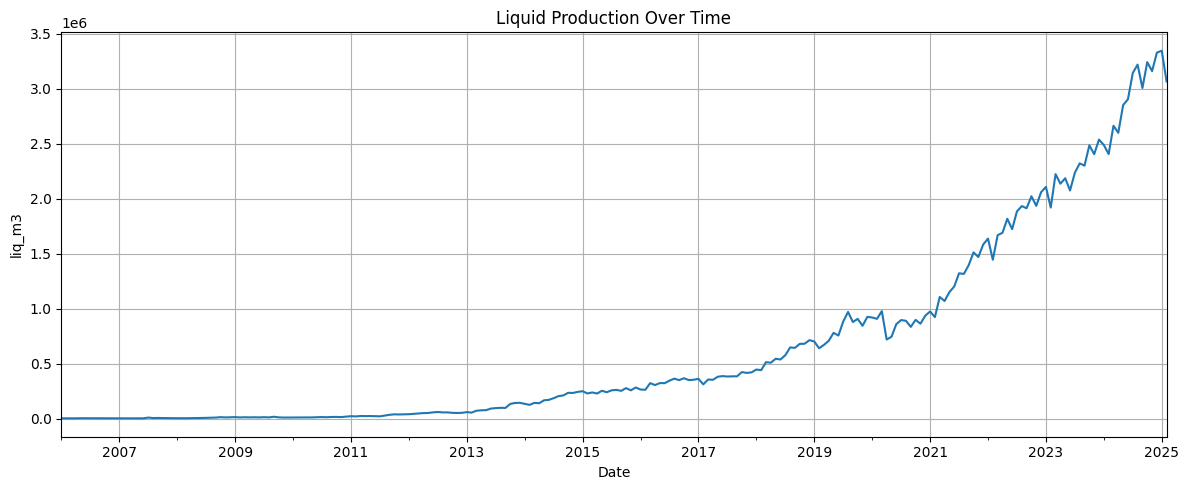

In [76]:
# Plotting liq_m3 vs time
plt.figure(figsize=(12, 5))
df_liq['liq_m3'].plot()
plt.title("Liquid Production Over Time")
plt.ylabel("liq_m3")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()